In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from glob import glob
import pickle

In [22]:
def scenario_to_title(scenario):
    scenario = scenario.split("/")[-1]
    scenario = scenario.replace("tau_", "Variant 1: ")
    scenario = scenario.replace("_var2_1.4_seed2p", "")
    scenario = scenario.replace("_5", ", Location: 5")
    scenario = scenario.replace("_seed2t_", ", Emergence Day: ")
    scenario = scenario.replace("_cross1by2_", ", Cross Immunity: ")
    scenario = scenario.replace("1.00", "0.00").replace("0.75", "0.25").replace("0.25", "0.75")
#     scenario = scenario.replace("", "")
    return scenario

def get_counts(data, offset):
    data = np.array(data[offset])
    data = np.concatenate(data)
    _, counts = np.unique(data, return_counts=True)
    return pd.Series(counts).value_counts()

def plot_profile(data, ax, scenario, offset, variant = "1", inf_line=None, reinf_line=None):
    data.plot(kind="bar", ax=ax)
    ax.set_title(f"Variant: {variant} Binary Infection Node Profile\n" + scenario_to_title(scenario) + f"\n{offset} Cumulative Population Prevalence Cutoff")
    ax.set_xlabel(f"# Replicates Node Infected by Variant {variant}")
    ax.set_ylabel("# Nodes")
    ax.set_yscale('log')
    
    if inf_line is not None:
        ax.axvline(inf_line, linestyle="--", color="tab:blue")
    if reinf_line is not None:
        ax.axvline(inf_line, linestyle="--", color="tab:orange")
        
def old_plot_scenario(scenario):
    with open(f"/scratch/jho5ze/bionets/epihiper/data/node_profiles/{exp}/archive/{scenario}_replicate_60_node_binary_infection_profile.pkl", "rb") as src:
        replicate_data = pickle.load(src) 

    date_offsets = [30, 60, 90]

    fig, axs = plt.subplots(figsize=(32, 6), ncols=4)

    for ix, offset in enumerate(date_offsets):
        data = get_counts(replicate_data, offset)
        plot_profile(data, axs[ix], scenario, offset)
        
    plt.tight_layout()
    
def get_bins_needed_for_rep_coverage(orig_data, offset):
    data = np.array(orig_data[offset])
    data = np.concatenate(data)
    unique, counts = np.unique(data, return_counts=True)
    count_to_nodes = {i:[] for i in np.unique(counts)}
    for ix, node in enumerate(unique):
        if "rep" in node:
            continue
        count_to_nodes[counts[ix]].append(node)
    node_to_reps = {int(node):[] for node in unique if "rep" not in str(node)}
    for rep_data in orig_data[offset]:
        rep = rep_data[0]
        for node in rep_data[1:]:
            node_to_reps[node].append(rep)
            
    running_reps = set()
    for rep_count in range(max(counts),0,-1):
        new_reps = [node_to_reps[int(node)] for node in count_to_nodes[rep_count]]
        new_reps = set(np.array(new_reps).ravel())
        running_reps = running_reps.union(new_reps)
        if len(running_reps) == 60:
            break

    return rep_count
    
def plot_scenario(scenario, var = 2):
    
    base = "/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/nodeProfiles"
    
    if int(var) == 1:
        with open(f"{base}/{exp}/{scenario}_node_V1_binary_infection_profile.pkl", "rb") as src:
            replicate_data = pickle.load(src)
            
        ncols = 3
        nrows = 1
    else: 
        with open(f"{base}/{exp}/{scenario}_node_V2_binary_infection_profile.pkl", "rb") as src:
            replicate_data = pickle.load(src)
            
        with open(f"{base}/{exp}/{scenario}_node_V2_from_V1_reinfection_profile.pkl", "rb") as src:
            replicate_data_reinfection = pickle.load(src)
        
        ncols=2
        nrows=2

    profile_prevs = pd.read_csv(f"{base}/{exp}/{scenario}_node_cumulative_cutoff_prevalence_info_for_profiles.csv")

    prev_cutoffs = [0.001, 0.01, 0.1]

    fig, axs = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows = nrows)

    for ix, cutoff in enumerate(prev_cutoffs):
        ax = axs[ix // 2, ix % 2] if int(var) == 2 else axs[ix]
        bins_needed_for_v2_replicates = get_bins_needed_for_rep_coverage(replicate_data, cutoff)
        bins_needed_for_v2_reinfection_replicates = get_bins_needed_for_rep_coverage(replicate_data_reinfection, cutoff)
        
        if int(var) == 1:
            data = get_counts(replicate_data, cutoff)
        else:
            re_counts = get_counts(replicate_data_reinfection, cutoff)
            counts = get_counts(replicate_data, cutoff)

            data = pd.DataFrame([counts, re_counts]).T
            data.columns = ["Infection", "Reinfection"]
        plot_profile(data, ax, scenario, cutoff, variant = var, inf_line=bins_needed_for_v2_replicates, reinf_line=bins_needed_for_v2_reinfection_replicates)
        
    if int(var) == 2:
        ax = axs[1,1]
        v2_prevs = profile_prevs[profile_prevs.variant == 2]
        sns.boxplot(data = v2_prevs, x = "cutoff", y = "v2_prev_at_cutoff", ax=ax)
        ax.set_title(f"Variant: {var} Binary Infection Node Profile\n" + scenario_to_title(scenario) + f"\nVariant 2 Prevalence at Cutoffs")
        ax.set_ylabel("Variant 2 Prevalence")
        ax.set_xlabel("Cutoff")

    plt.tight_layout()

<ipython-input-2-738e19cd796b>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data[offset])


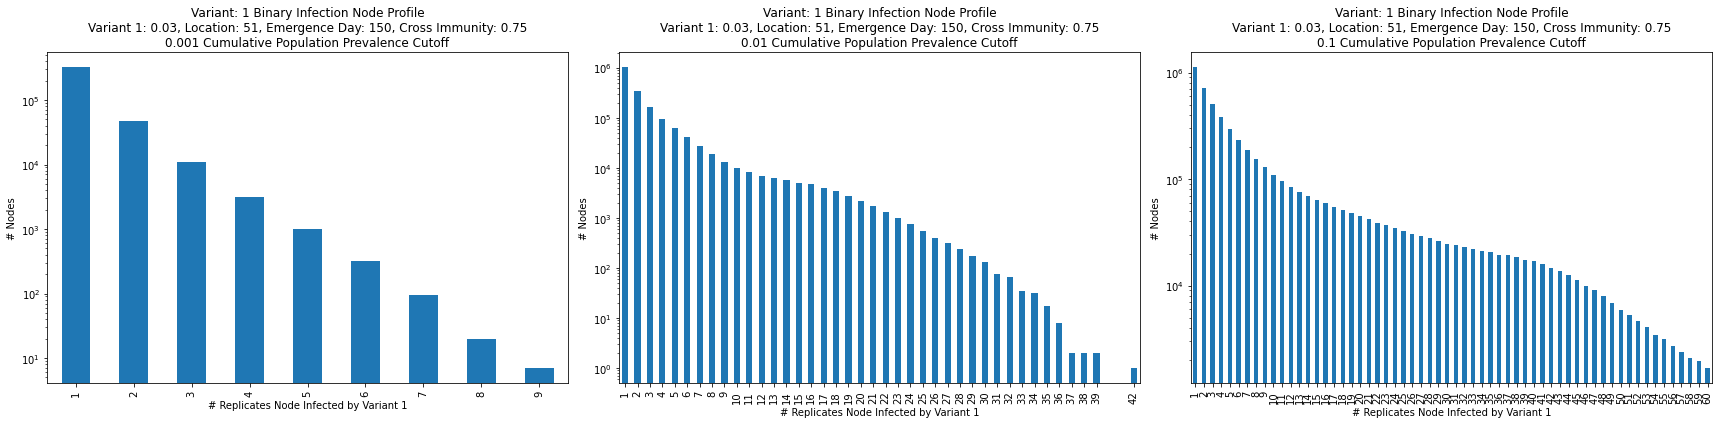

In [74]:
var = 1

base = "/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/nodeProfiles"

if int(var) == 1:
    with open(f"{base}/{exp}/{scenario}_node_V1_binary_infection_profile.pkl", "rb") as src:
        replicate_data = pickle.load(src)

    ncols = 3
    nrows = 1
else: 
    with open(f"{base}/{exp}/{scenario}_node_V2_binary_infection_profile.pkl", "rb") as src:
        replicate_data = pickle.load(src)

    ncols=2
    nrows=2

profile_prevs = pd.read_csv(f"{base}/{exp}/{scenario}_node_cumulative_cutoff_prevalence_info_for_profiles.csv")

prev_cutoffs = [0.001, 0.01, 0.1]

fig, axs = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows = nrows)

for ix, cutoff in enumerate(prev_cutoffs):
    ax = axs[ix // 2, ix % 2] if int(var) == 2 else axs[ix]
    data = get_counts(replicate_data, cutoff)
    plot_profile(data, ax, scenario, cutoff, variant = var)

if int(var) == 2:
    ax = axs[1,1]
    v2_prevs = profile_prevs[profile_prevs.variant == 2]
    sns.boxplot(data = v2_prevs, x = "cutoff", y = "v2_prev_at_cutoff", ax=ax)
    ax.set_title(f"Variant: {var} Binary Infection Node Profile\n" + scenario_to_title(scenario) + f"\nVariant 2 Prevalence at Cutoffs")
    ax.set_ylabel("Variant 2 Prevalence")
    ax.set_xlabel("Cutoff")

plt.tight_layout()

In [7]:
base = "/project/biocomplexity/biosurveillance/EpiHiper/postProcessing/nodeProfiles"

scenario = scenarios[-1]

with open(f"{base}/{exp}/{scenario}_node_V2_from_V1_reinfection_profile.pkl", "rb") as src:
    replicate_data_reinfection = pickle.load(src)
    
with open(f"{base}/{exp}/{scenario}_node_V2_binary_infection_profile.pkl", "rb") as src:
    replicate_data = pickle.load(src)

In [4]:
base_data = "/gpfs/gpfs0/project/bii_nssac/COVID-19_USA_EpiHiper/rivanna/20210827-var_surv"
exp = "exp7"
scenarios = [i.split("/")[-1] for i in glob(f"{base_data}/{exp}/*")]
len(scenarios)

72

<ipython-input-22-0e11ae928ffc>:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(orig_data[offset])
<ipython-input-22-0e11ae928ffc>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data[offset])


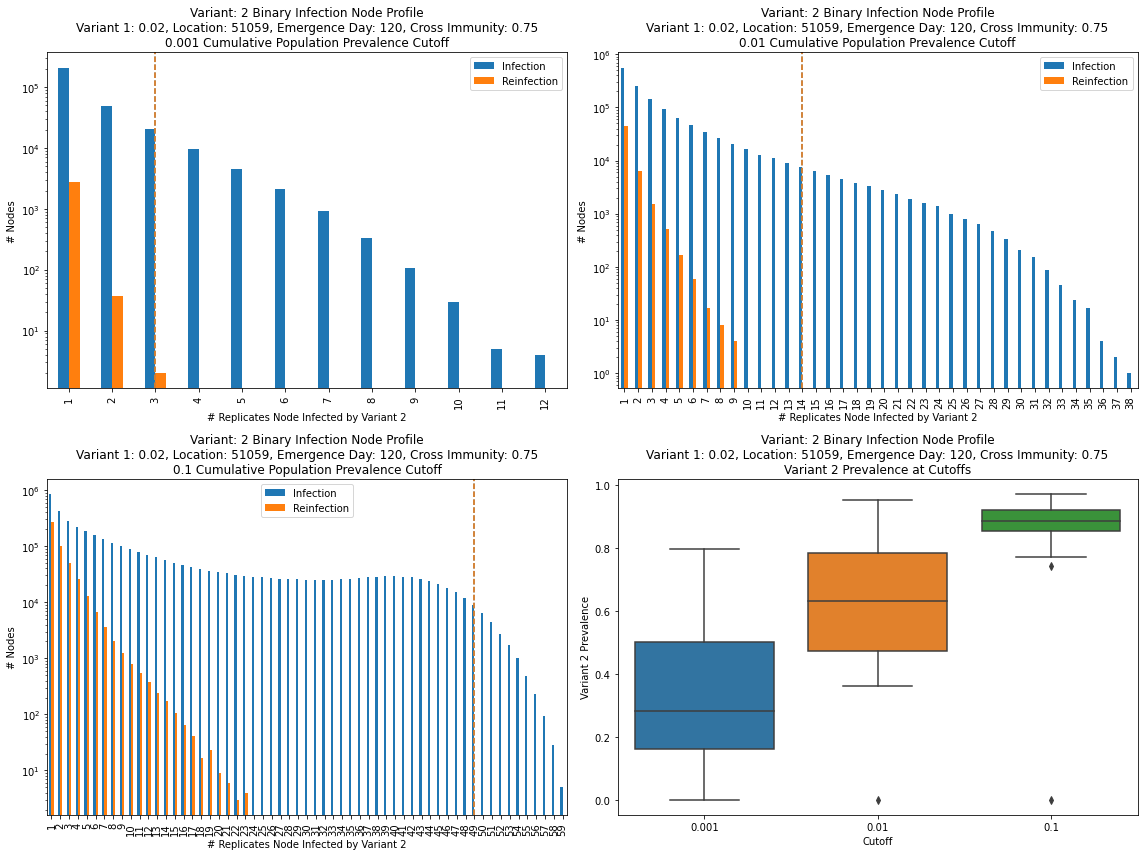

In [23]:
plot_scenario(scenarios[-1], var=2)
plt.savefig("node_V2_reinfection_profile_example_VA.png", dpi=100, facecolor="white")


<ipython-input-6-593f35dec47e>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data[offset])


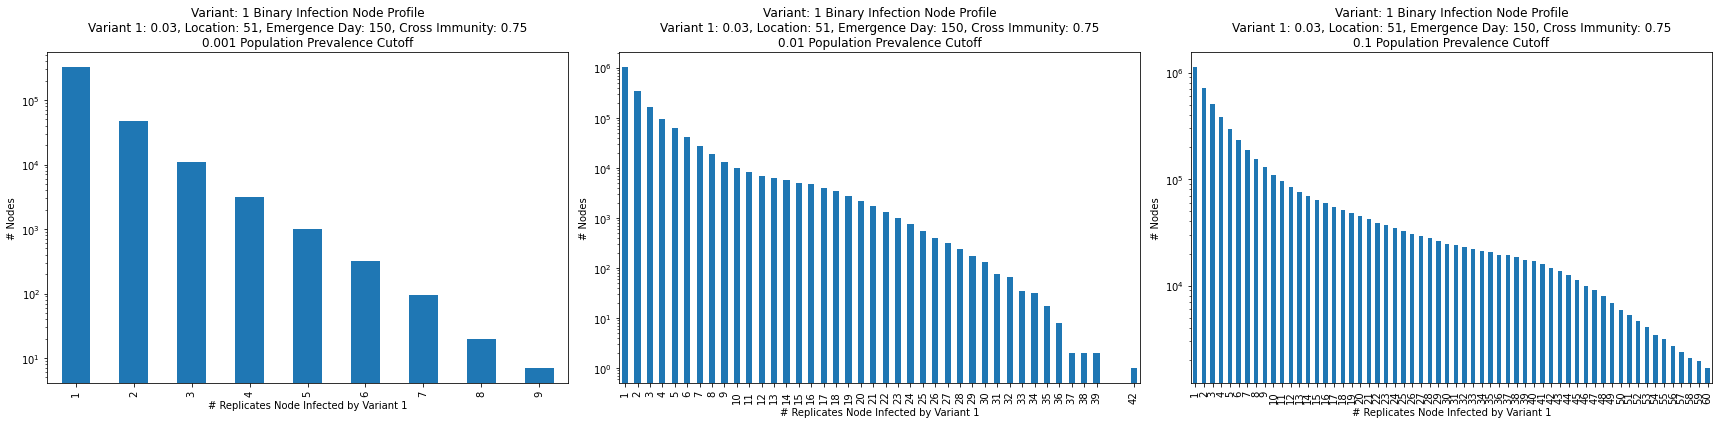

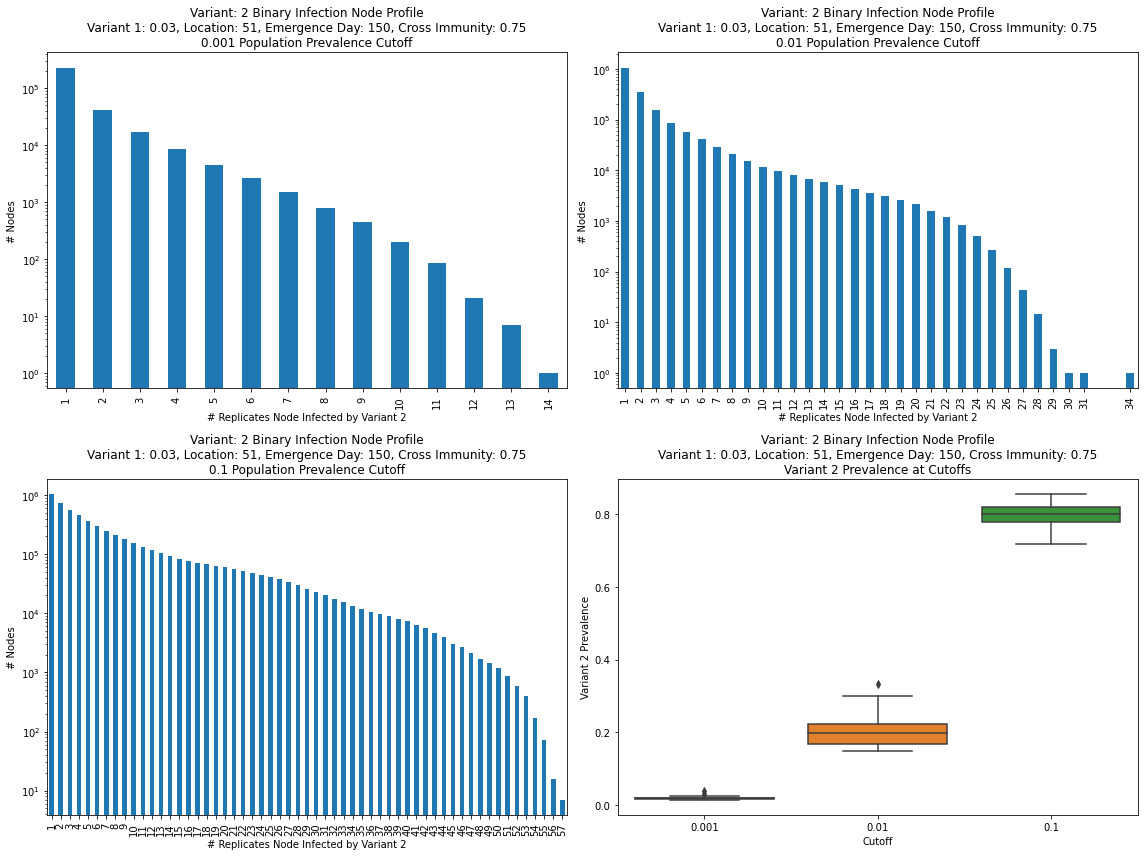

In [24]:
plot_scenario(scenarios[0], var=1)
plt.savefig("node_V1_binary_infection_profile_example_VA.png", dpi=100, facecolor="white")

plot_scenario(scenarios[0], var=2)
plt.savefig("node_V2_binary_infection_profile_example_VA.png", dpi=100, facecolor="white")

<ipython-input-6-593f35dec47e>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data[offset])


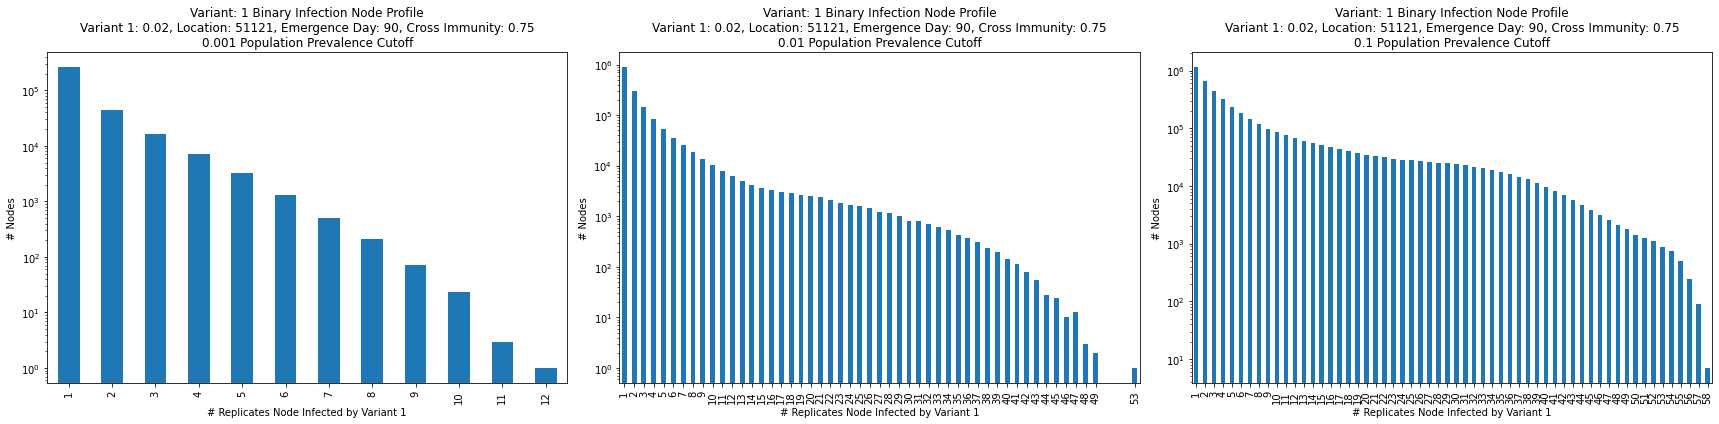

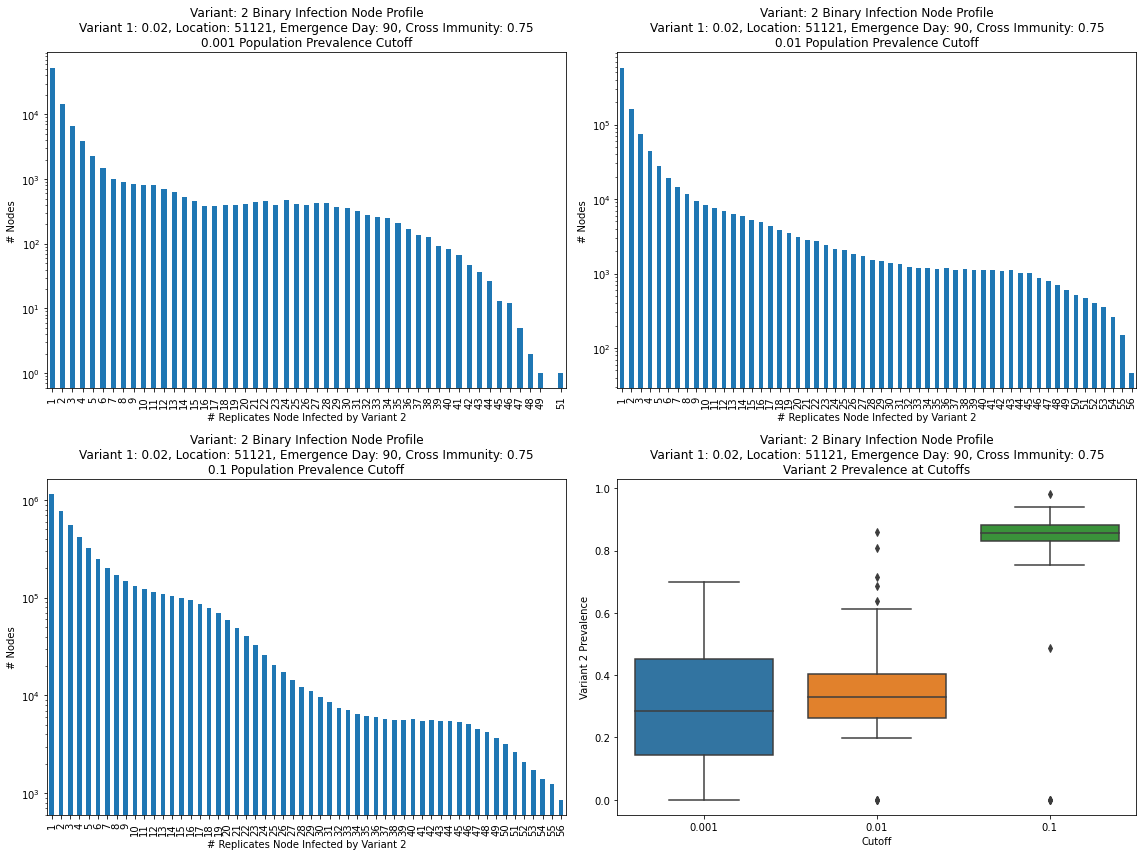

In [22]:
plot_scenario(scenarios[10], var=1)
plt.savefig("node_V1_binary_infection_profile_example_Montgomery.png", dpi=100, facecolor="white")

plot_scenario(scenarios[10], var=2)
plt.savefig("node_V2_binary_infection_profile_example_Montgomery.png", dpi=100, facecolor="white")

<ipython-input-41-96d22d845cad>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data[offset])


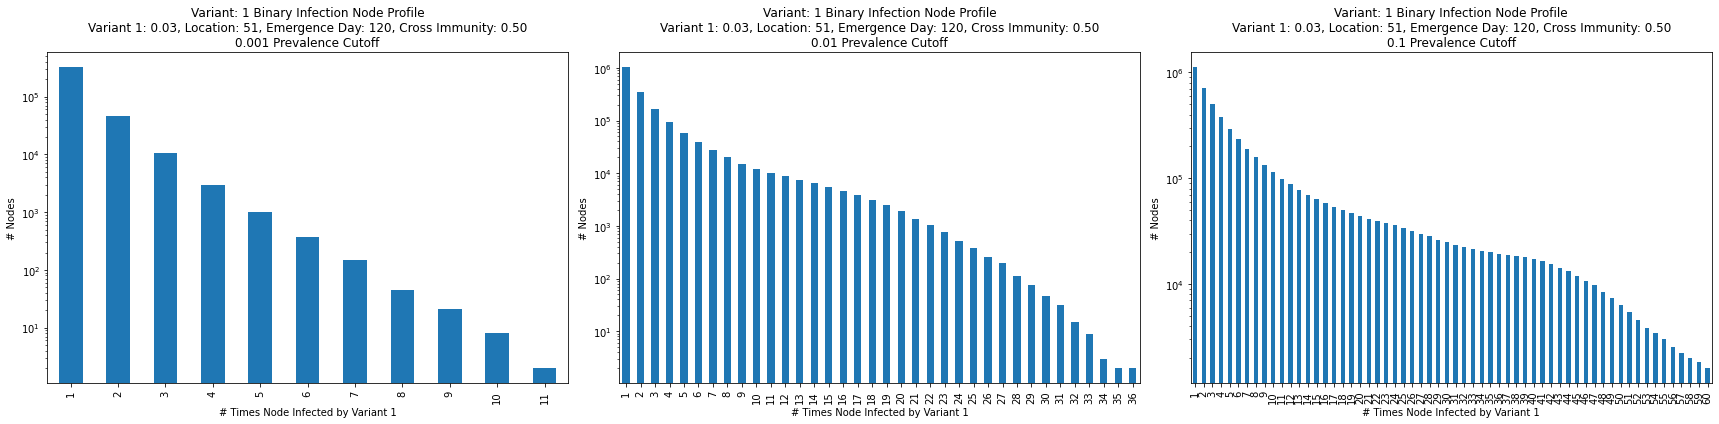

In [46]:
plot_scenario(scenarios[1], var=1)
plt.savefig("node_V1_binary_infection_profile_example.png", dpi=100, facecolor="white")

### Old Plots

<ipython-input-12-8a141320ae8a>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data[offset])


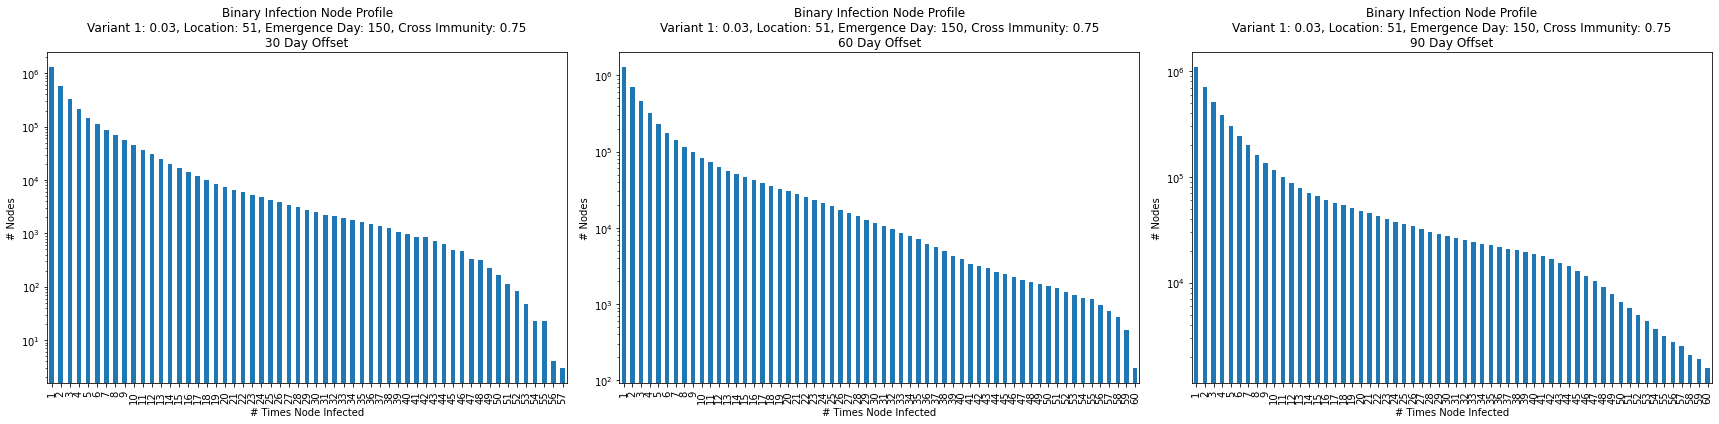

In [13]:
plot_old_scenario(scenarios[0])
plt.savefig("node_binary_infection_profile_example.png", dpi=100, facecolor="white")

<ipython-input-85-c09cd5060fc9>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(replicate_data[offset])


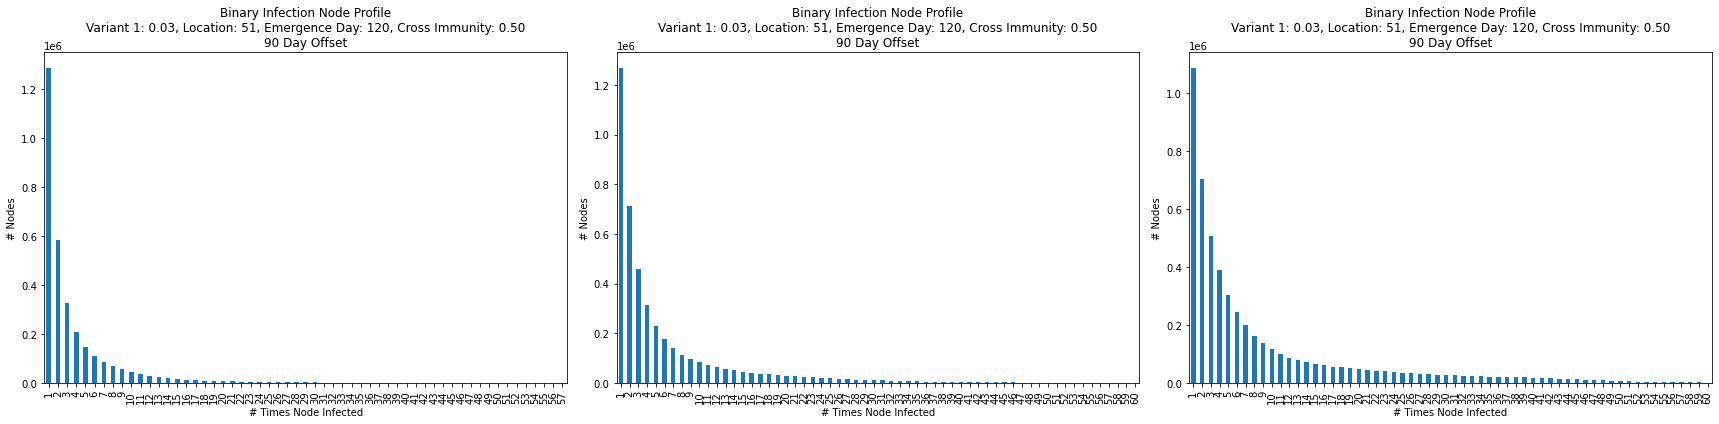

In [87]:
plot_old_scenario(scenarios[1])

<ipython-input-85-c09cd5060fc9>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(replicate_data[offset])


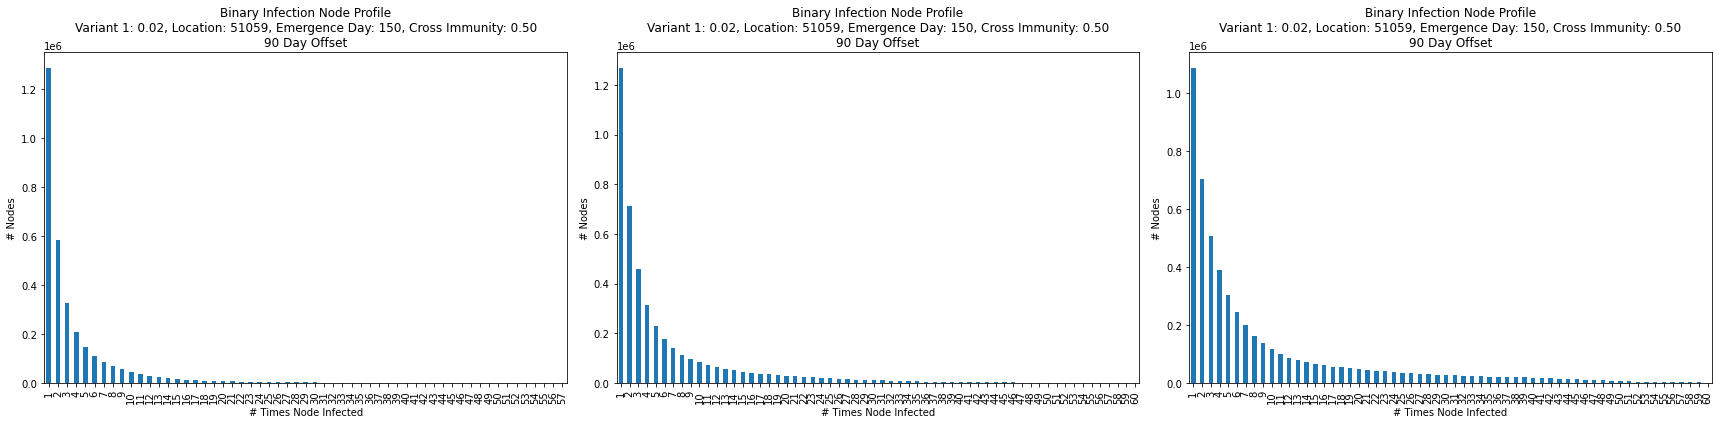

In [88]:
plot_old_scenario(scenarios[2])